This notebook is to convert *binary* boosted trees defined by LightGBM to TreeGrad so that it can be trained using GPUs

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-alpha0 treegrad
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

In [19]:
from sklearn.datasets import make_classification
import lightgbm as lgb
X, y = make_classification(100, n_classes=2, n_informative=3, n_redundant=0, n_clusters_per_class=2, n_features=10)
lgb_model = lgb.LGBMClassifier(n_estimators=3)
lgb_model.fit(X, y)
nclass = lgb_model.n_classes_
print(lgb_model.predict(X))

[0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0
 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0]


In [0]:
from treegrad.tree_utils import multi_tree_to_param

model_dump = lgb_model.booster_.dump_model()
trees_ = [m["tree_structure"] for m in model_dump["tree_info"]]
trees_params = multi_tree_to_param(X, y, trees_)

In [0]:
weights = trees_params[0]
sparse_info = trees_params[1]
routes_list = trees_params[2]

------

Now we recreate the node layer definitions

In [0]:
# to build tree model, it is just a three layer neural network - lets see how we go...
from tensorflow.keras.constraints import max_norm, MinMaxNorm
from tensorflow.keras import constraints

'''
class NodeLayer(tf.keras.layers.Layer):
    def __init__(self, num_nodes):
        super(NodeLayer, self).__init__()
        self.num_nodes = num_nodes
    
    def build(self, input_shape):
        # we may want a sparse one later...ignore it for now
        self.sparse = self.add_variable("sparse", 
                                    shape=[int(input_shape[-1]), 
                                           self.num_nodes],
                                    trainable=False)
        self.kernel = self.add_variable("kernel", regularizer='l1', constraint=max_norm(2), shape=[self.num_nodes,])
        self.bias = self.add_variable("bias", regularizer='l1', constraint=max_norm(2), shape=[self.num_nodes,])
    
    def call(self, input):
        return tf.matmul(input, tf.concat([self.kernel * self.sparse, -self.kernel * self.sparse], 1)) + tf.concat([self.bias, -self.bias], 0)
'''


class NodeLayer(tf.keras.layers.Layer):
    def __init__(self, num_nodes):
        super(NodeLayer, self).__init__()
        self.num_nodes = num_nodes
    
    def build(self, input_shape):
        # we may want a sparse one later...ignore it for now
        self.kernel = self.add_variable("sparse", 
                                    shape=[int(input_shape[-1]), 
                                           self.num_nodes],
                                    regularizer='l1',
                                    trainable=True)
        self.bias = self.add_variable("bias", constraint=MinMaxNorm(1., 2.), shape=[self.num_nodes,])
    
    def call(self, input):
        return tf.matmul(input, tf.concat([self.kernel, -self.kernel], 1)) + tf.concat([self.bias, -self.bias], 0)


    
def gumbel_softmax(x, tau=0.01):
    x_temp = tf.clip_by_value(x/tau, -32, 32)
    return 1/(1+tf.keras.backend.exp(-x))

def activation1(x):
    return tf.keras.backend.log(tf.clip_by_value(gumbel_softmax(x),tf.keras.backend.epsilon(), 1.))

def activation2(x):
    return tf.keras.backend.exp(tf.clip_by_value(x, -32, 0))



In [0]:


# now we have to construct the tree...
inputs = tf.keras.Input(shape=(10,))
decision_tree_layers = []
for tree_idx in range(len(sparse_info)):
    num_nodes = sparse_info[tree_idx].shape[1]
    decision_tree_layers.append(
        tf.keras.Sequential([
            NodeLayer(num_nodes),
            tf.keras.layers.Lambda(activation1),
            tf.keras.layers.Dense(num_nodes+1, trainable=False, use_bias=False),
            #tf.keras.layers.Lambda(lambda x: tf.matmul(x, routes_list[tree_idx].T.astype(np.float32))),
            tf.keras.layers.Lambda(activation2),
            tf.keras.layers.Dense(1, use_bias=False)
        ], name='decision_tree_{}'.format(tree_idx))(inputs)
    )
log_preds = tf.keras.layers.Add()(decision_tree_layers)
log_preds = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -32, 32))(log_preds)
preds = tf.keras.layers.Activation('sigmoid')(log_preds)
model = tf.keras.Model(inputs=inputs, outputs=preds)


In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
decision_tree_0 (Sequential)    (None, 1)            61          input_2[0][0]                    
__________________________________________________________________________________________________
decision_tree_1 (Sequential)    (None, 1)            61          input_2[0][0]                    
__________________________________________________________________________________________________
decision_tree_2 (Sequential)    (None, 1)            61          input_2[0][0]                    
____________________________________________________________________________________________

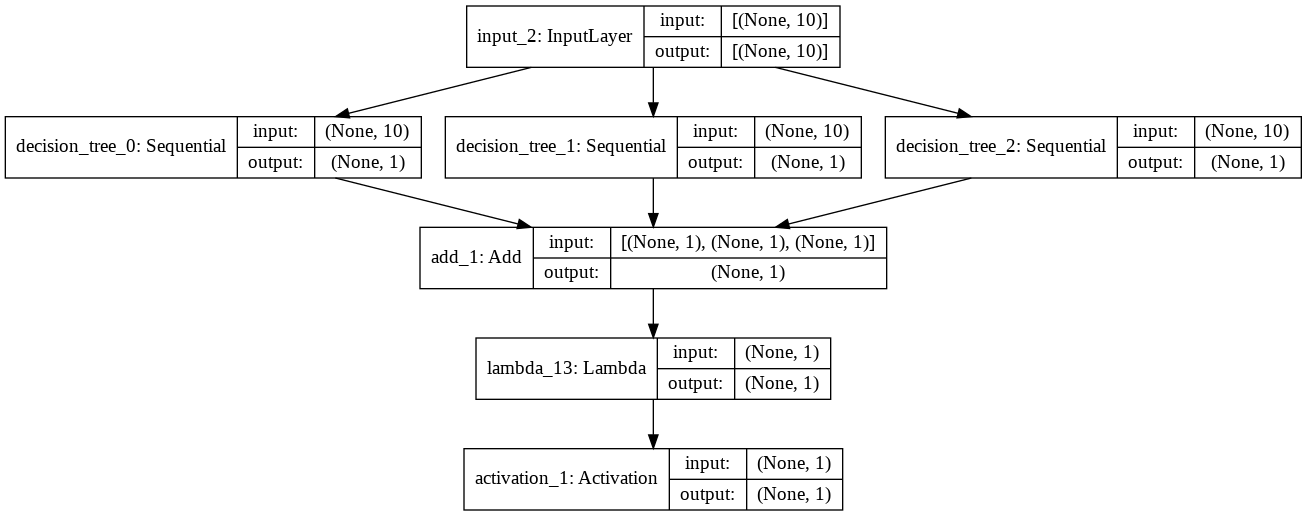

In [25]:
tf.keras.utils.plot_model(model, 'boosted_tree.png', show_shapes=True)


In [0]:
tree_pred = []
num_unpack = 3
for idx in range(0, len(weights), num_unpack):
    param = weights[idx:idx+num_unpack]
    other_idx = idx//num_unpack
    coef, inter, leaf = param
    sparse = sparse_info[other_idx]
    route = routes_list[other_idx]
    #model.layers[other_idx+1].layers[0].set_weights([coef, inter, sparse])
    model.layers[other_idx+1].layers[0].set_weights([coef*sparse, inter])
    model.layers[other_idx+1].layers[2].set_weights([route.T])
    # we didn't transfer leaves...
    model.layers[other_idx+1].layers[4].set_weights([leaf[:, np.newaxis]])


In [31]:
# let's train and see what happens
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.fit(X, y, epochs=1000, verbose=0)

In [37]:
accuracy_score(y, np.round(model.predict(X)))

0.78

In [38]:
accuracy_score(y, lgb_model.predict(X))


0.81